# Isolation Forest
*For Anomaly Detection*

Isolation forest is decision tree based ensemble method that explicitly identifies **anomalous** datapoints. This is in contrast to profiling normal instances and then identifying the instances which don't conform to this profile. Anomalies are few and have feature-values that are different from normal points. Isolation forest capitalizes on these characteristics of anomalies. I present a small example before proceeding with the technical aspects of then algorithm.

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# default plot settings
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['axes.facecolor'] = 'lightskyblue'
plt.rcParams['axes.titlepad'] = 35.0
rng = np.random.RandomState(42)

In [8]:
'''Initialize Models Here'''
clf = IsolationForest(behaviour='new', max_samples=100,
                      random_state=rng, contamination=0.11)

rfc = RandomForestClassifier(n_estimators=1000, random_state=42, max_features=1.,
                             class_weight='balanced')

In [9]:
def conf_matrix(Y_true, Y_pred, fig, z=1, labels = [1, -1], target_names = ['Regular', 'Anomaly'], split_name="Test Set", model_name="Isolation forest"):
    
    cm = confusion_matrix(Y_true,Y_pred,labels)
    # print("confusion matrix=")    
    # print(cm)
    
    #print(classification_report(Y_true, Y_pred, target_names=target_names))
    ax = fig.add_subplot(1,2,z)
    cax = ax.matshow(cm,cmap='YlGn',interpolation='nearest') #plt.cm.Blues
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j,i,cm[i,j], fontsize=15)
    ax.set_title('Confusion matrix for {} with model = {}'.format(split_name, model_name), fontsize=12)
    ax.set_xticklabels([''] + target_names)
    ax.set_yticklabels([''] + target_names)
    ax.set_xlabel('Predicted', fontsize='large')
    ax.set_ylabel('True', fontsize='large')
    return ax
    #plt.show()
    

In [10]:
distributions = ['normal', 'poisson', 'exponential', 'gumbel']
regular_dist = np.random.choice(distributions,1)[0] 
irregular_dist = np.random.choice(list(filter(lambda x: x != regular_dist, distributions)), 1)[0]

data_gen = getattr(rng,regular_dist)
anomaly_gen = getattr(rng, irregular_dist)

print("regular distribution is : {}".format(regular_dist))
print("anomalous distribution is : {}".format(irregular_dist))

regular distribution is : normal
anomalous distribution is : exponential


In [11]:
'''train data'''
X_train = 0.2 * data_gen(size=(1000, 2))
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])
print("training: {}".format(X_train.shape))

'''regular test data'''
X_test = 0.2* data_gen(size=(200, 2))
X_test = np.r_[X_test+3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])
print("normal test: {}".format(X_test.shape))

'''anomalous test data'''
X_outliers = anomaly_gen(size=(100,2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])
print("anomalous test: {}".format(X_outliers.shape))


training: (2000, 2)
normal test: (400, 2)
anomalous test: (100, 2)


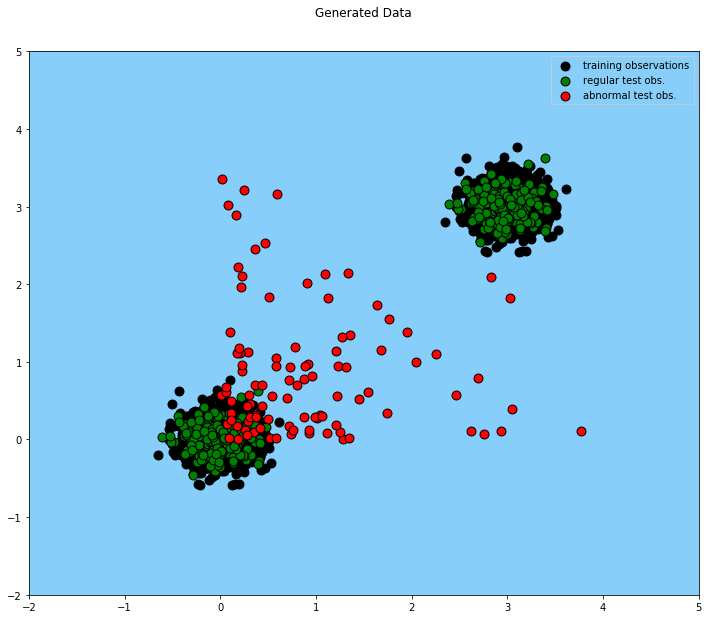

In [12]:
'''Plotting generated data ----'''

plt.title("Generated Data")

p1 = plt.scatter(X_train.x1, X_train.x2, c='black',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_test.x1, X_test.x2, c='green',
                 s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red',
                s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3],
           ["training observations",
            "regular test obs.", "abnormal test obs."],
           loc="best")

plt.show()

In [13]:

clf.fit(X_train)

'''predictions'''
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

'''accuracies'''
print("Accuracy on normal samples: {}".format(list(y_pred_test).count(1)/y_pred_test.shape[0]))
print("Accuracy on anomalous samples: {}".format(list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0]))

Accuracy on normal samples: 0.915
Accuracy on anomalous samples: 0.89


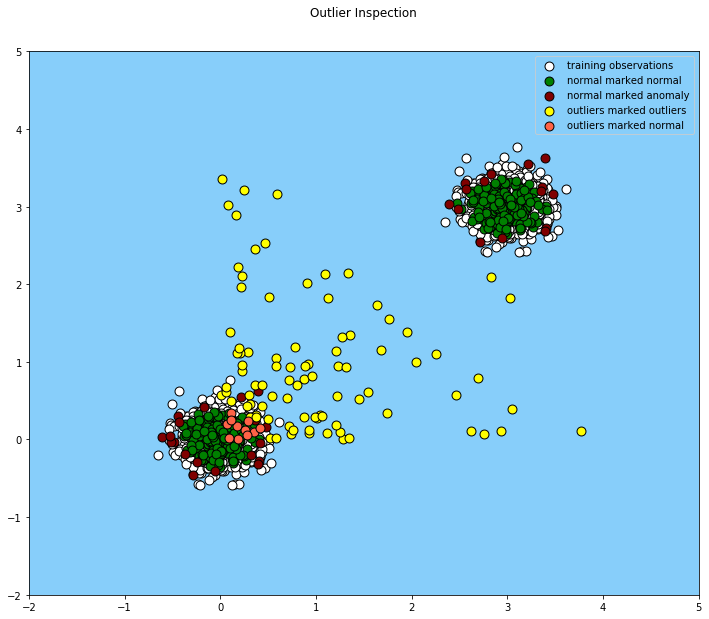

In [15]:
'''Plotting predictions'''

X_outliers = X_outliers.assign(y = y_pred_outliers)
X_test = X_test.assign(y = y_pred_test)

plt.title("Outlier Inspection")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_test.loc[X_test.y == 1, ['x1']], 
                 X_test.loc[X_test.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k')
p3 = plt.scatter(X_test.loc[X_test.y == -1, ['x1']], 
                 X_test.loc[X_test.y == -1, ['x2']], 
                 c='maroon', s=20*4, edgecolor='k')
p4 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='yellow', s=20*4, edgecolor='k')
p5 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='tomato', s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3, p4, p5],
           ["training observations",
            "normal marked normal",
            "normal marked anomaly",
            "outliers marked outliers", 
            "outliers marked normal"],
           loc="best")

plt.show()

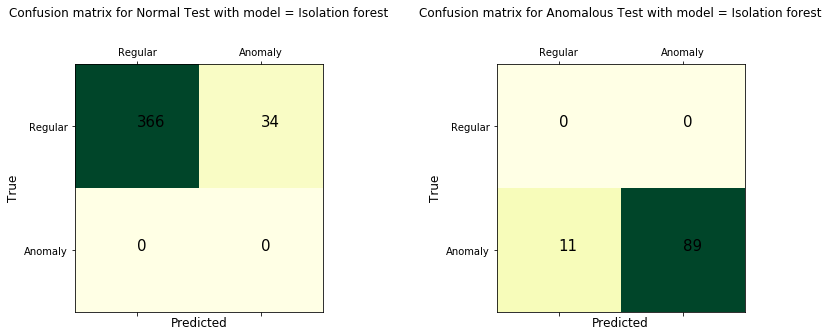

In [16]:
'''Confusion Matrix for test set (regular observations)'''
y_test_test = [1]*X_test.shape[0]
fig1 = plt.figure(figsize=(12,10))
conf_matrix(y_test_test, y_pred_test, fig1, z=1, split_name="Normal Test")

'''Confusion Matrix for test set (anomalies)'''
y_test_outliers = [-1]*X_outliers.shape[0]
conf_matrix(y_test_outliers, y_pred_outliers, fig1, z=2, split_name="Anomalous Test")

fig1.subplots_adjust(wspace=0.7)
plt.show()


In [17]:
'''Isolation and Random Forest on really bad dataset'''
path = 'resources/pacemed/'
df = pd.read_csv(path+'cleaned.csv',index_col=None, sep=',')
df['bad_discharge'] = df['bad_discharge'].astype('int')
df.head()

,primary_key,blood_pressure,respiration_rate,temperature,age,days_ICU,bad_discharge
0,0-2016-01-05,133.367285,3.331333,35.746152,35.0,2.0,0
1,1-2014-07-04,127.878761,5.333333,37.133845,77.0,2.0,0
2,10-2015-07-02,109.261078,5.775556,37.405126,50.0,3.0,0
3,100-2014-06-28,128.925084,6.390000,36.293589,41.0,1.0,0
4,1000-2014-11-30,118.448189,8.975610,37.572649,79.0,2.0,0


In [18]:
Data = df.iloc[:,1:df.shape[1]-1].values
Target = df['bad_discharge'].values
X_train3, X_test3, y_train3, y_test3 = train_test_split(Data, Target, test_size=0.20, random_state=0, stratify=Target)
print('Training Features Shape:', X_train3.shape)
print('Training Labels Shape:', y_train3.shape)
print('Testing Features Shape:', X_test3.shape)
print('Testing Labels Shape:', y_test3.shape)


clf.fit(X_train3)
rfc.fit(X_train3,y_train3)

y_pred_iso = clf.predict(X_test3)
y_pred_rfc = rfc.predict(X_test3)


Training Features Shape: (1119, 5)
Training Labels Shape: (1119,)
Testing Features Shape: (280, 5)
Testing Labels Shape: (280,)


In [19]:
y_test_new = []
for yt in y_test3.tolist():
    if yt==0:
        y_test_new.append('Good')
    else:
        y_test_new.append('Bad')
        
y_pred_new = []
for yt in y_pred_iso.tolist():
    if yt==1:
        y_pred_new.append('Pred_Good')
    else:
        y_pred_new.append('Pred_Bad')
        
data = np.stack((X_test3[:, 2], X_test3[:,1], y_test_new, y_pred_new)).T
new_df = pd.DataFrame(data, columns=['x', 'y', 'if.act', 'if.pred'])
new_df['x'] = new_df['x'].astype('float')
new_df['y'] = new_df['y'].astype('float')

In [20]:
y_pred_rf = []
for yt in y_pred_rfc.tolist():
    if yt==0:
        y_pred_rf.append('Pred_Good')
    else:
        y_pred_rf.append('Pred_Bad')
        
rf_data = np.stack((X_test3[:, 2], X_test3[:,1], y_test_new, y_pred_rf)).T
rf_df = pd.DataFrame(rf_data, columns=['x', 'y', 'rf.act', 'rf.pred'])
rf_df['x'] = rf_df['x'].astype('float')
rf_df['y'] = rf_df['y'].astype('float')


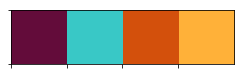

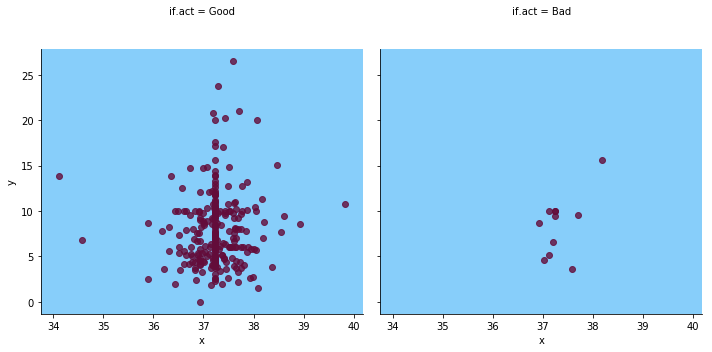

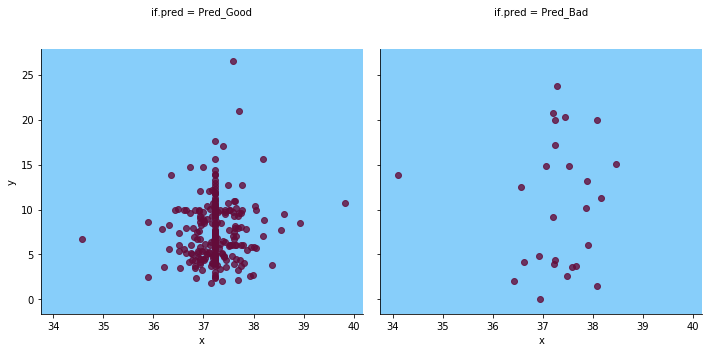

In [29]:
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

sns.lmplot(data=new_df, x='x', y='y', col='if.act', 
                   fit_reg=False, legend=True, legend_out=True)

sns.lmplot(data=new_df, x='x', y='y', col='if.pred', 
                   fit_reg=False, legend=True, legend_out=True)

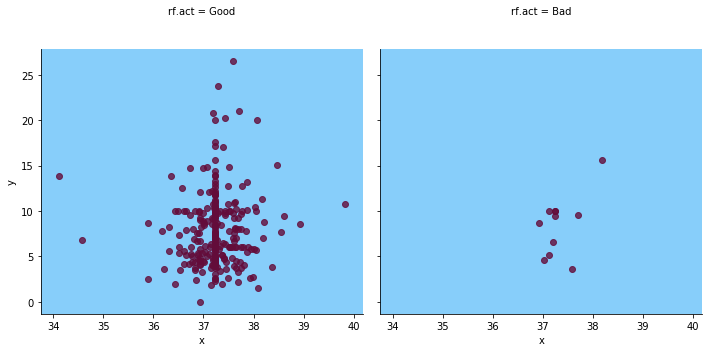

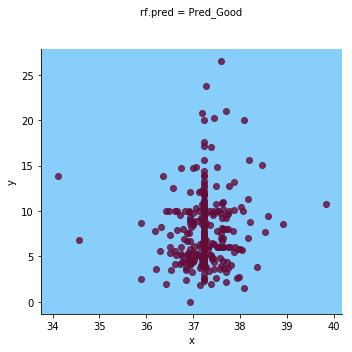

In [30]:
sns.lmplot(data=rf_df, x='x', y='y', col='rf.act', 
                   fit_reg=False, legend=True, legend_out=True)

sns.lmplot(data=rf_df, x='x', y='y', col='rf.pred', 
                   fit_reg=False, legend=True, legend_out=True)


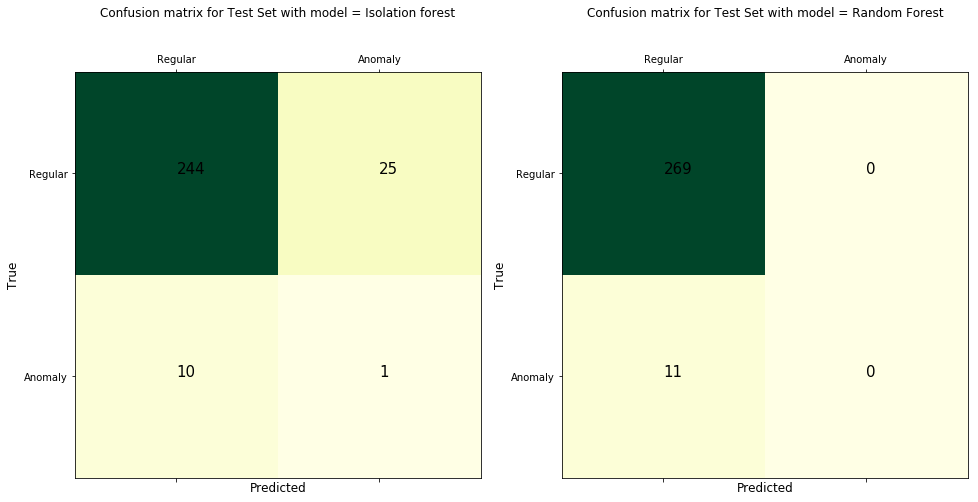

In [32]:
#Confusion Matrix Isolation forest
y_cf_iso = []
for yt in y_pred_iso.tolist():
    if yt==1:
        y_cf_iso.append(0)
    else:
        y_cf_iso.append(1)
fig = plt.figure(figsize=(16,12))
conf_matrix(y_test3,y_cf_iso,fig, labels=[0, 1], z=1 )
conf_matrix(y_test3, y_pred_rfc, fig, labels= [0, 1], model_name="Random Forest", z=2)
fig1.subplots_adjust(wspace=2.5)
plt.show()
